### import general python modules

In [1]:
% matplotlib inline
from __future__ import print_function
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

### import of tomography functions
These functions are part of the tomography package and are needed to compute the results.

In [2]:
from tomography import \
    read_data, \
    topo_phase_removal, \
    calculate_covariance_matrix, \
    capon_beam_forming_inversion

from tomography.ancillary import listfiles, normalize, geocode

from tomography.plotting import DataViewer, Tomographyplot, GeoViewer

### define input parameters
This is the only box which needs to be changed, all others runs automatically.  
* `inpath` a directory containing all the files provided with this tutorial.  
* `outpath` will be used by the notebook to write intermediate and final results to disk.

Furthermore, two processing parameters can be adjusted:
* `multi_look` defines the size of the smoothing kernel, which is applied to the covariance matrix
* `height` defines the maximum inversion height (in meters) to be computed during capon beam forming inversion

In [3]:
inpath = 'E:/Dokumente/Skripte/python/PycharmProjects/tomography/data'
outpath = 'E:/Dokumente/Skripte/python/PycharmProjects/tomography/out'

# define the boxcar smoothing dimension
multi_look = 10

# define the max height for the inversion
height = 70

### create the output directory and list the files to be imported
The function `listfiles` which is used here scans the defined input directory `inpath` for the files provided with this tutorial.  
All files matching the defined [regular expression](https://docs.python.org/3/library/re.html) pattern are listed.

You can print the lists by e.g. adding the following line: 
```python
print('\n'.join(slc_list))
```

In [4]:
if not os.path.exists(outpath):
    os.makedirs(outpath)

slc_list = listfiles(inpath, 'SLC_[0-9]_20151013_L_hv$')
phase_list = listfiles(inpath, 'Pha_[0-9]_20151013_L_hv$')
kz_list = listfiles(inpath, 'Kz_[0-9]_20151013_L_hv$')

### read the images into memory

In the following step the image files are stacked into [numpy ndarrays](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) and then written to disk using [pickle](https://docs.python.org/3.6/library/pickle.html) serialization.

For each stack a filename to write the result to has to be defined.  
In case this file already exists, the stacking is not performed and the array is directly read from disk.

If you want to overwrite the result, add `overwrite=True` to the call of `read_data`.

In [5]:
# read SLC data
outname = os.path.join(outpath, 'SLC_stack')
slc_stack = read_data(slc_list, outname, overwrite=False)

# read files containing flat earth and topographical phase
outname = os.path.join(outpath, 'phase_stack')
phase_stack = read_data(phase_list, outname)

# read wavenumber files
outname = os.path.join(outpath, 'kz_stack')
kz_stack = read_data(kz_list, outname)

### visualization of input data
Now that we have loaded all data we can have a first look at the input data by running the next box.

The SLC is displayed as amplitude in logarithmic scaling linearly stretched between the 2nd and 98th percentile.  
Use the slider to scroll trough the individual images.

IntSlider(value=1, continuous_update=False, description='file number', layout=Layout(align_items='stretch', bo…

<IPython.core.display.Javascript object>


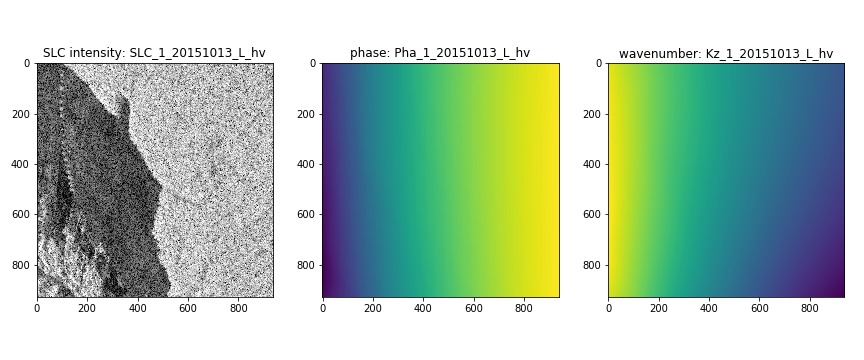

In [6]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (12, 5)

view = DataViewer(slc_list, phase_list, kz_list, slc_stack, phase_stack, kz_stack)

### removal of topographic phase

In the next step we want to normalize the SLC phase by subtracting the topographic phase images

In [7]:
outname = os.path.join(outpath, 'normalized_stack')
normalized_stack = topo_phase_removal(slc_stack, phase_stack, outname)

### computation of the covariance matrix

In [8]:
outname = os.path.join(outpath, 'cov_matrix_ml{}'.format(multi_look))
covariance_matrix = calculate_covariance_matrix(normalized_stack, outname, multi_look)

### capon beam forming inversion



In [9]:
# capon beam forming inversion
outname = os.path.join(outpath, 'capon_bf_ml{}_h{}'.format(multi_look, height))
capon_bf = capon_beam_forming_inversion(covariance_matrix, kz_stack, outname, height)

### normalization of tomography result

In [10]:
# compute absolute values of the inversion result
capon_bf_abs = np.absolute(capon_bf)

# normalize the absolute beam forming inversion result per-pixel
caponnorm = np.apply_along_axis(normalize, 2, capon_bf)

### plotting of the tomography result

<IPython.core.display.Javascript object>


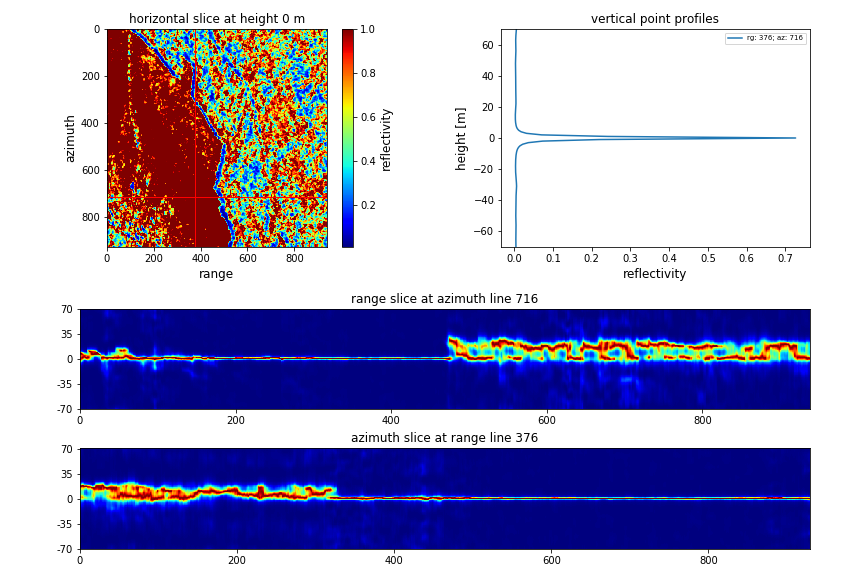

In [11]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (12, 8)
view = Tomographyplot(capon_bf_abs, caponnorm)

### geocoding

In this section we are going to warp the results from radar coordinates to geo coordinates using two geocoded lookup tables (LUTs). 
The geocoded LUTs contain radar coodinates as pixel values such that for each geocoded pixel the value of the range and azimuth LUT can be used to get the corresponding pixel from the image in radar coordinates. This is exemplified in the following code snippet:
```python
rg_index = lut_rg[0, 0]
az_index = lut_az[0, 0]
img_geo[0, 0] = img_radar[az_index, rg_index]
```

In [12]:
# first we define the names of the LUTs, which are provided with this tutorial:
lut_range = os.path.join(inpath, 'sr2geo_rg_15tmpsar0409_L_t02.rat')
lut_azimuth = os.path.join(inpath, 'sr2geo_az_15tmpsar0409_L_t02.rat')

# then we define a name for the output dataset.
outname = os.path.join(outpath, 'capon_bf_ml{}_h{}_geo'.format(multi_look, height))

# The data in this tutorial is only a subset of a larger dataset which is linked to the LUTs. 
# Thus, the function geocode needs to internally convert the pixel coordinates to those of the original data set.
# Here we define the radar pixel coordinates of our subset within the original dataset:
rg_min = 1610
rg_max = 2547
az_min = 17324
az_max = 18252

In [13]:
# now we can perform the actual geocoding:
geocode(capon_bf_abs, lut_range, lut_azimuth, outname, rg_min, rg_max, az_min, az_max)

# Providing a different input dataset of the tutorial, e.g. the SLC data, to the function would work just as well.

### plotting of the geocoded tomography result

We can use the GeoViewer class to display the file written by geocode. On moving the slider, the selected band is read directly from the file and then displayed. The coordinate reference system is now WGS 84, UTM 32N with coordinate units being meters.

IntSlider(value=1, continuous_update=False, description='band number', layout=Layout(align_items='stretch', bo…

<IPython.core.display.Javascript object>


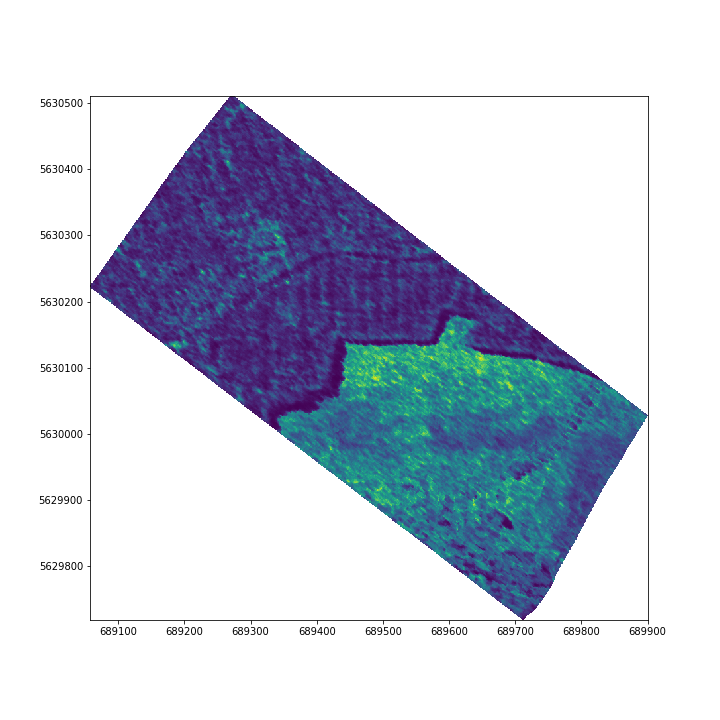

In [14]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
view = GeoViewer(outname)